In [1]:
##library 
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from numpy import sort
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import bokeh
import sklearn
import xgboost as xgb
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.mlab as mlab
import sqlite3
import matplotlib.pyplot as plt
from scipy import stats



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
##import properties 2016  data
##gives warning, check why

prop2016= pd.read_csv('C:\\Users\\Dell\\Desktop\\inf552\\Zillow Prize\\properties_2016.csv')
##import train 2016  data
train2016=pd.read_csv('C:\\Users\\Dell\\Desktop\\inf552\\Zillow Prize\\train_2016.csv',parse_dates=["transactiondate"])

##merge
df_train = train2016.merge(prop2016, how='left', on='parcelid')
df_train['transaction_month'] = df_train['transactiondate'].dt.month

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

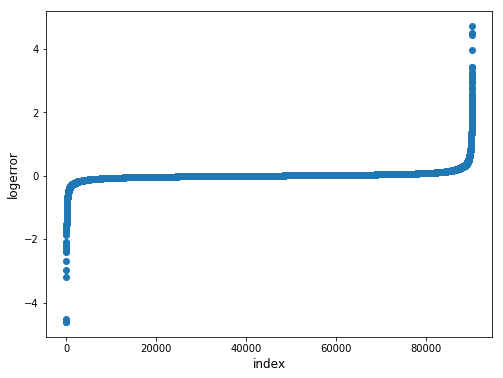

In [4]:
#Logerror:

#Target variable for this competition is "logerror" field. So let us do some analysis on this field first.

plt.figure(figsize=(8,6))
plt.scatter(range(df_train.shape[0]), np.sort(df_train.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

#Observation : some outliers at both the ends.!

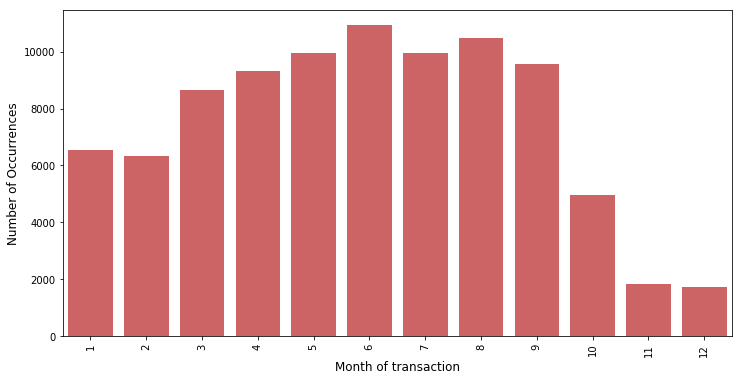

In [5]:
#Transaction Date:

#Now let us explore the date field. Let us first check the number of transactions in each month.


df_train['transaction_month'] = df_train['transactiondate'].dt.month

cnt_srs = df_train['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

#Observation

#As we could see from the data description as well The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.
#So we have shorter bars in the last three months

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


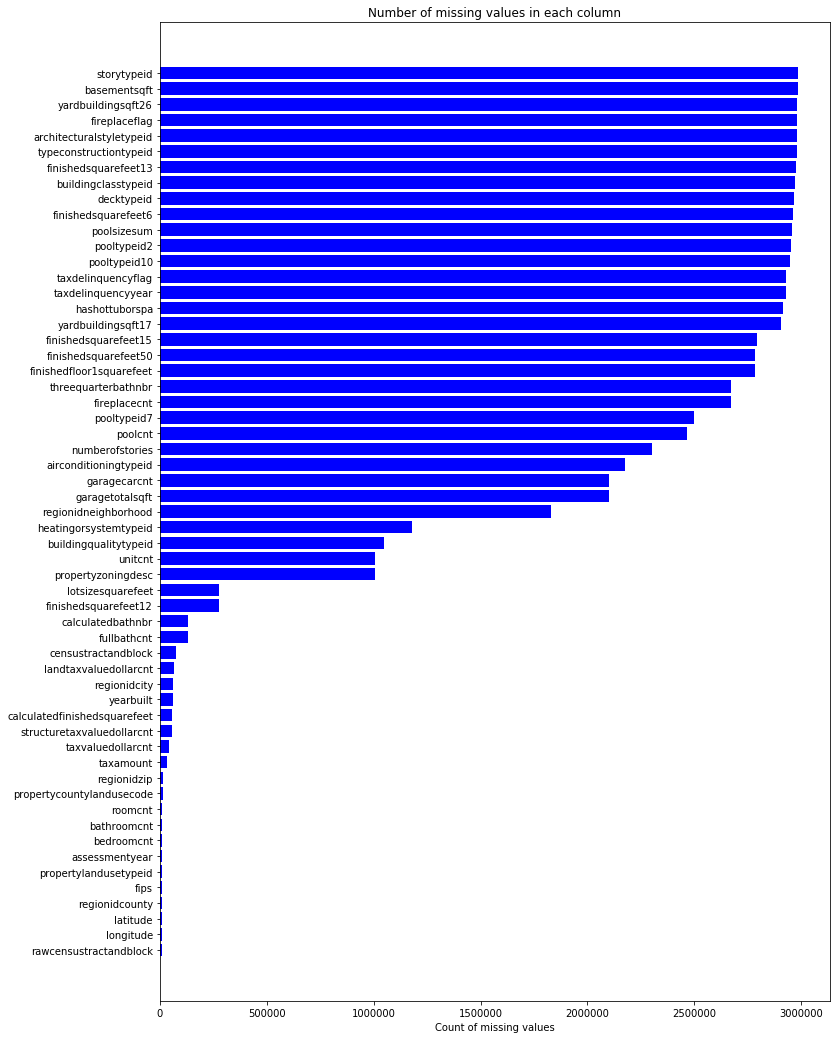

In [6]:
#Now let us explore the properties_2016 file.

#There are so many NaN values in the dataset. So let us first do some exploration on that one.

missing_df = prop2016.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

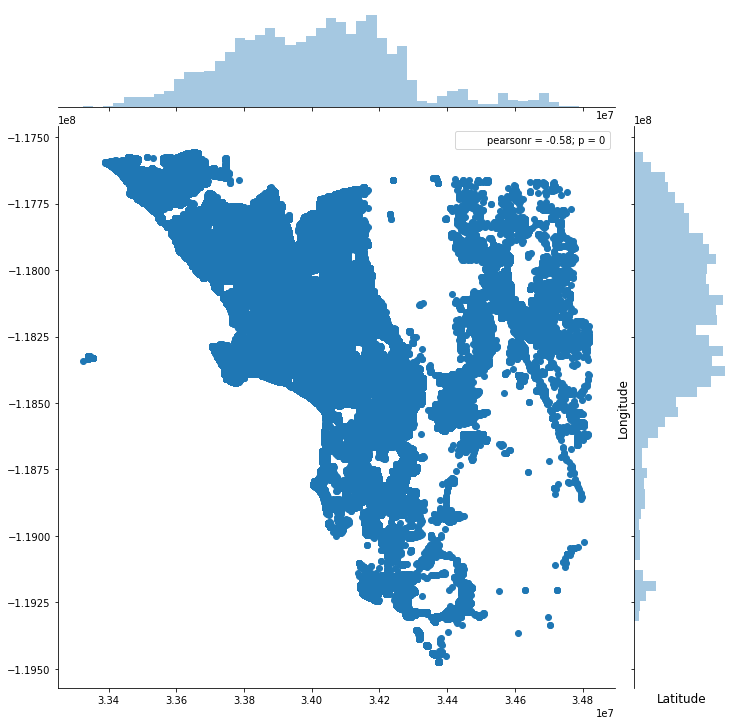

In [9]:
#Let us explore the latitude and longitude variable to begin with.

plt.figure(figsize=(12,12))
sns.jointplot(x=prop2016.latitude.values, y=prop2016.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

#observation
#From the data page, we are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


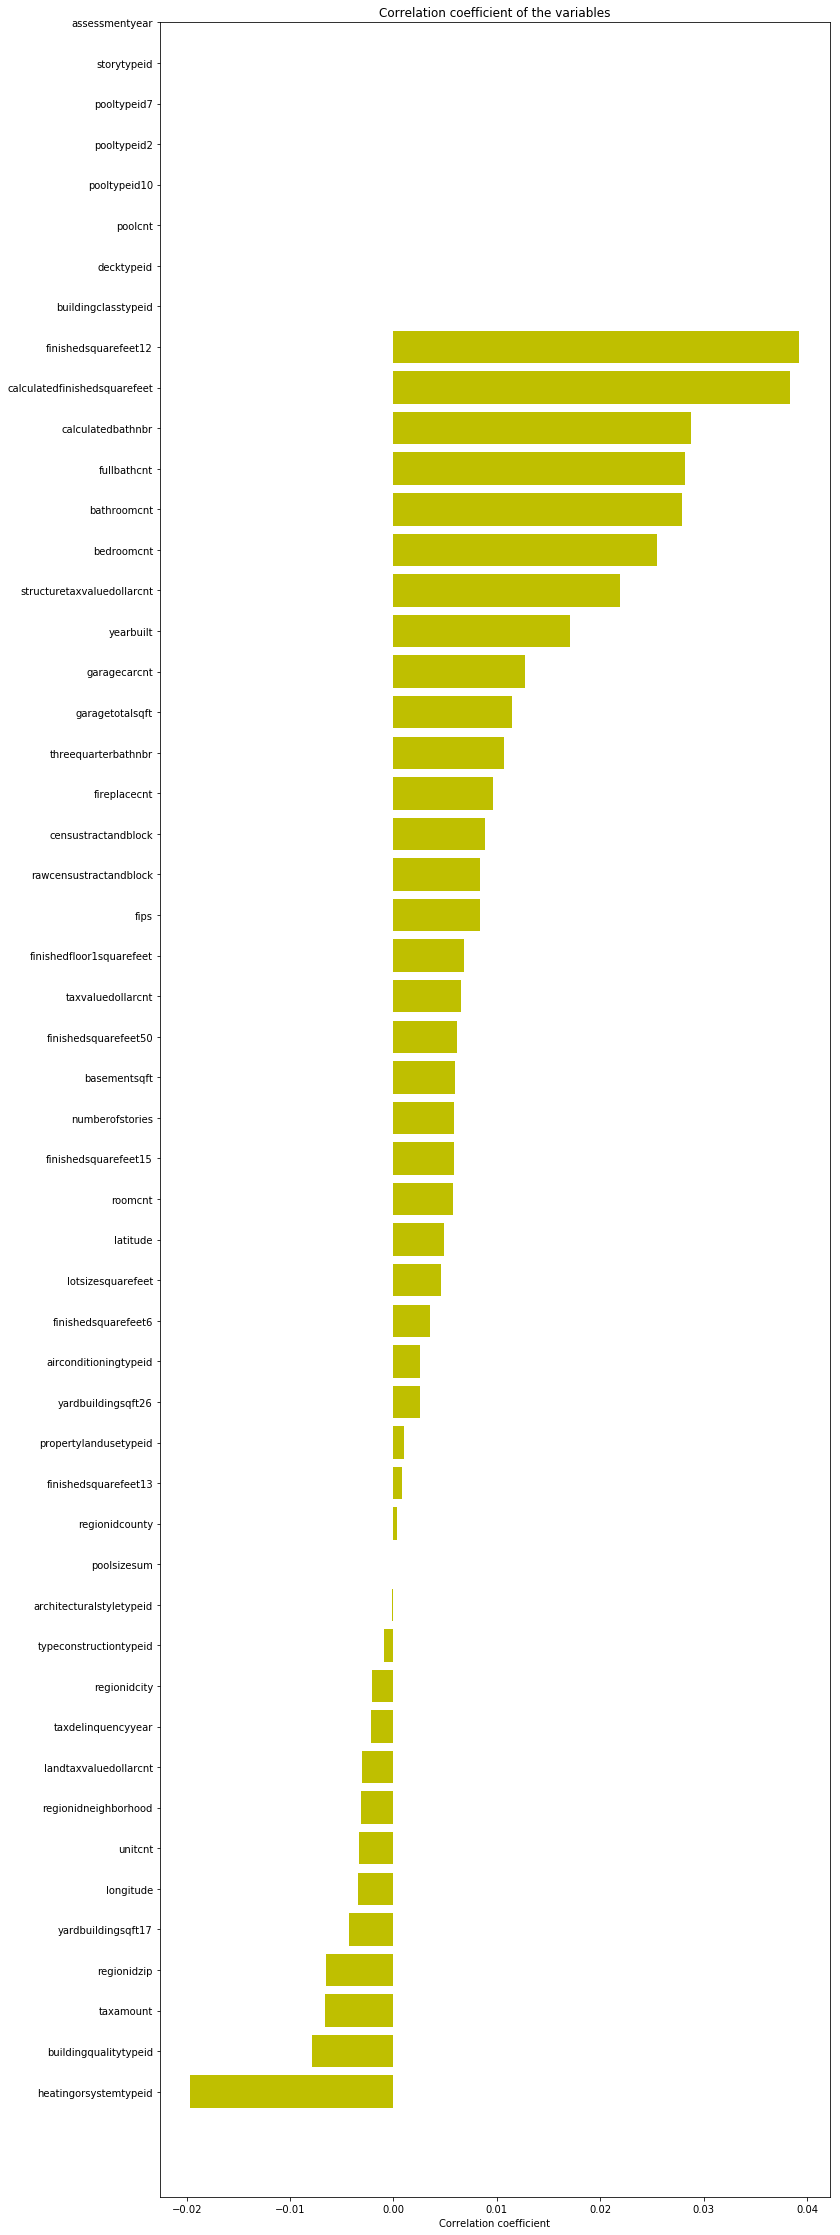

In [11]:
#Univariate Analysis:
#Since there are so many variables, let us first take the 'float' variables alone and then get the correlation with the target variable to see how they are related.

# Let us just impute the missing values with mean values to compute correlation coefficients #
mean_values = df_train.mean(axis=0)
df_train = df_train.fillna(mean_values, inplace=True)

# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in df_train.columns if col not in ['logerror'] if df_train[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df_train[col].values, df_train.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

#observation
#The correlation of the target variable with the given set of variables are low overall.

T#here are few variables at the top of this graph without any correlation values.

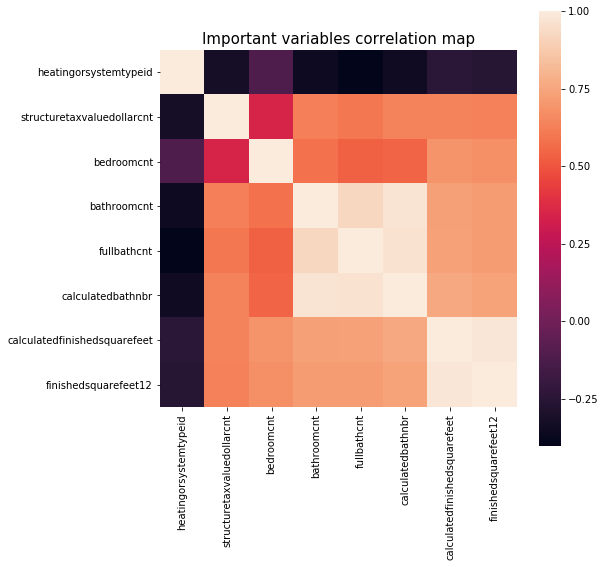

In [13]:
#Let us take the variables with high correlation values and then do some analysis on them

corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

cols_to_use = corr_df_sel.col_labels.tolist()

df_train = df_train[cols_to_use]
corrmat = df_train.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

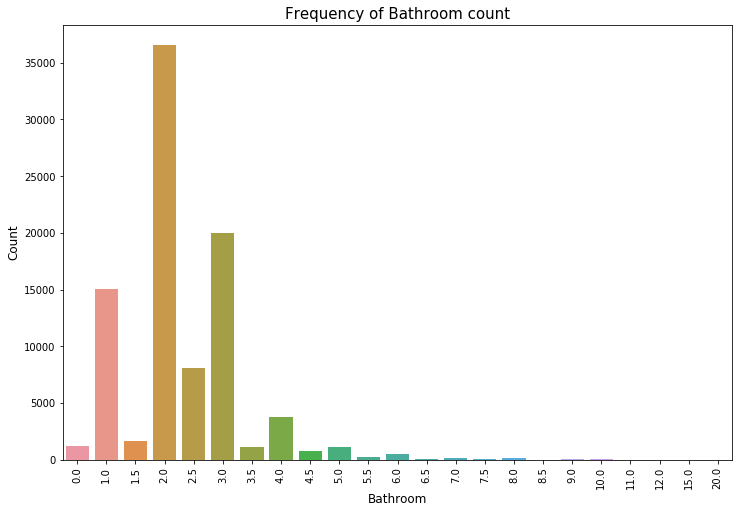

In [14]:
#exploring important attributes
#Bathroom Count:

plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=df_train)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

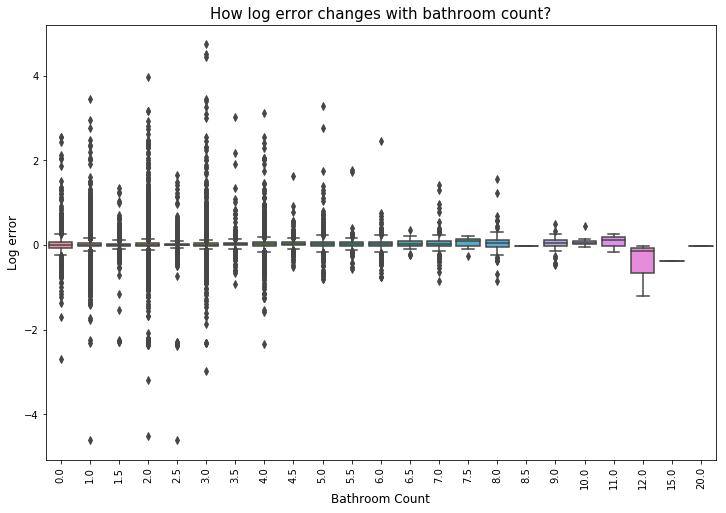

In [19]:
#how logerror changes with bathroom count 

plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt", y="logerror", data=df_train)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

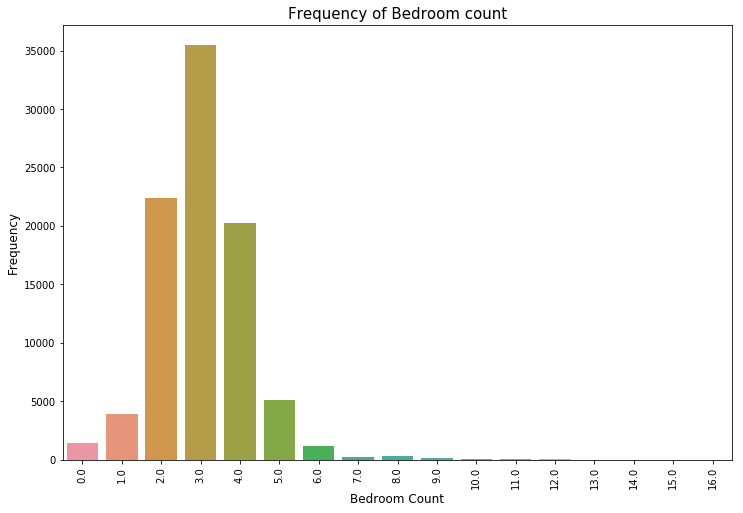

In [20]:
#Bedroom count:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=df_train)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

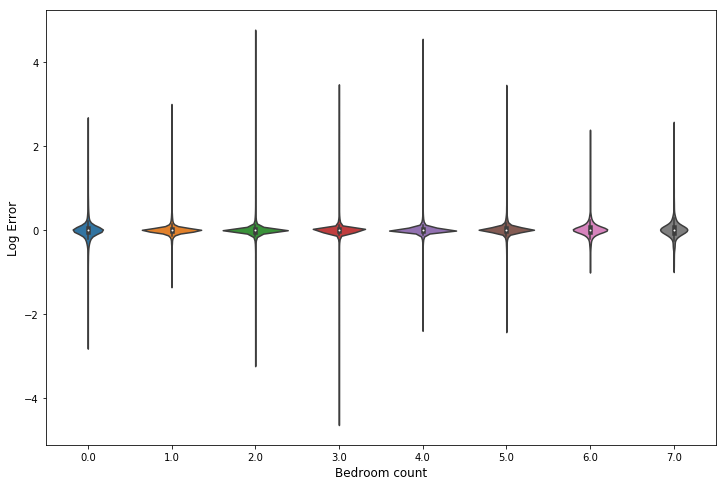

In [21]:
#
df_train['bedroomcnt'].loc[df_train['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=df_train)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


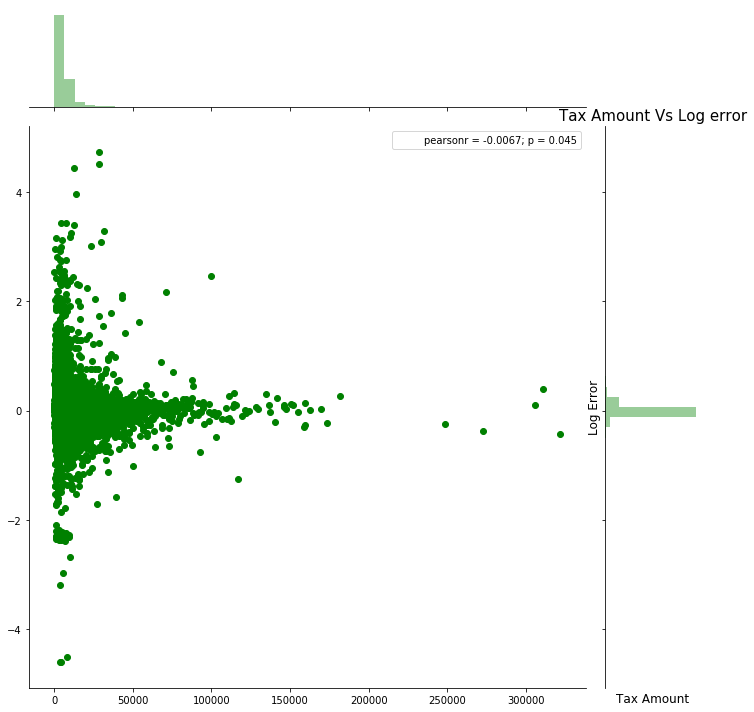

In [22]:
col = "taxamount"
ulimit = np.percentile(df_train[col].values, 99.5)
llimit = np.percentile(df_train[col].values, 0.5)
df_train[col].loc[df_train[col]>ulimit] = ulimit
df_train[col].loc[df_train[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=df_train['taxamount'].values, y=df_train['logerror'].values, size=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

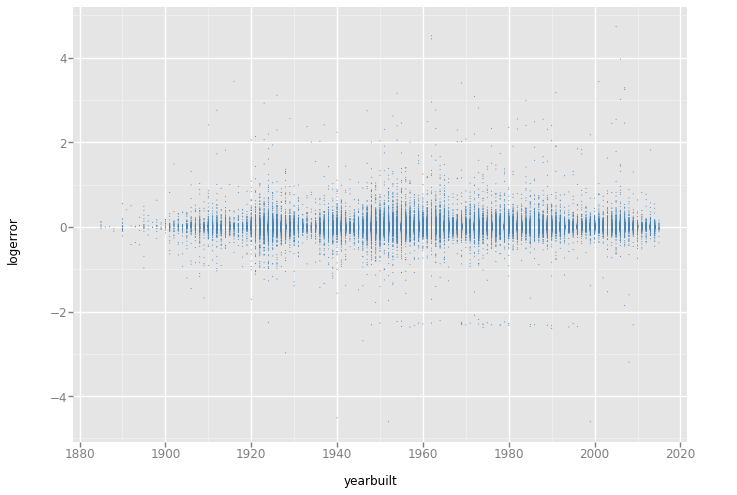

<ggplot: (-9223371865313907042)>

In [29]:
#YearBuilt:

#Let us explore how the error varies with the yearbuilt variable.

from ggplot import *
ggplot(aes(x='yearbuilt', y='logerror'), data=df_train) + geom_point(color='steelblue', size=1) 

#There is a minor incremental trend seen with respect to built year.

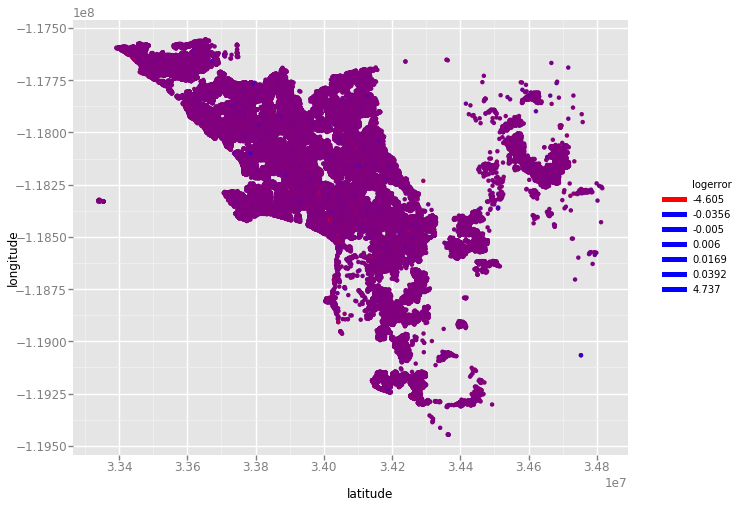

<ggplot: (-9223371865313699191)>

In [31]:
#Now let us see how the logerror varies with respect to latitude and longitude

ggplot(aes(x='latitude', y='longitude', color='logerror'), data=df_train) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'blue')